In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.layers import Dense, Dropout, BatchNormalization

# Load Data 

In [2]:
df = pd.read_csv('Preprocessed Data 3 Mar 2021.csv', index_col = 0)
df.head(5)

,Speed (km/h),Latitude coordinate (degrees),Longitude coordinate (degrees),Altitude (meters),Vertical accuracy (degrees),Horizontal accuracy (degrees),Course (degrees),Difcourse: course variation (degrees),Acceleration in X filtered by KF (Gs),Acceleration in Y filtered by KF (Gs),...,no speed limit,no lanes number,Type of road_motorway,Type of road_motorway_link,Type of road_primary,Type of road_primary_link,Type of road_tertiary_link,AGGRESSIVE,DROWSY,NORMAL
0,64.5,40.512924,-3.404577,612.5,4,5,331.9,0.000,-0.030,-0.015,...,0,0,0,0,0,0,0,0,0,1
1,63.6,40.513065,-3.404680,612.9,4,5,330.8,1.055,0.026,-0.012,...,0,0,0,0,0,0,0,0,0,1
2,62.2,40.513210,-3.404772,613.3,4,5,330.8,1.055,-0.021,-0.018,...,0,0,0,0,0,0,0,0,0,1
3,60.9,40.513348,-3.404868,613.5,3,5,330.1,0.703,0.025,0.006,...,0,0,0,0,0,0,0,0,0,1
4,61.2,40.513477,-3.404971,613.8,3,5,329.4,1.406,0.014,-0.031,...,0,0,0,0,0,0,0,0,0,1


# K-Fold Cross Validation

In [3]:
from sklearn.model_selection import KFold
X = df.iloc[:,:-3]
Y = df.iloc[:,-3:]
kf = KFold(n_splits=5, random_state=4, shuffle=True)

# Building Model

In [4]:
early_stopping = callbacks.EarlyStopping(
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True)

model = keras.Sequential()
model.add(Dense(100, activation='relu', input_shape=[X.shape[1]]))
model.add(Dropout(0.0009))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.0009))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.0009))
model.add(BatchNormalization())

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.0005))
model.add(BatchNormalization())

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.0001))
model.add(BatchNormalization())

model.add(Dense(Y.shape[1], activation='softmax'))

optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics = 'accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1

# Training

In [33]:
count = 0

for train_index, test_index in kf.split(X):
    print('Fold: ' + str(count))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40)

    model = keras.Sequential()
    model.add(Dense(100, activation='relu', input_shape=[X.shape[1]]))
    model.add(Dropout(0.001))
    model.add(BatchNormalization())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.001))
    model.add(BatchNormalization())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.001))
    model.add(BatchNormalization())

    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.00055))
    model.add(BatchNormalization())

    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.00015))
    model.add(BatchNormalization())

    model.add(Dense(Y.shape[1], activation='softmax'))

    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics = 'accuracy')

    model.summary()
    
    history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test), 
                    #batch_size = 22,
                    callbacks=[early_stopping],
                    epochs=600)
    
    if count == 0:
        history_fold_0 = pd.DataFrame(history.history)
    elif count == 1:
        history_fold_1 = pd.DataFrame(history.history)
    elif count == 2:
        history_fold_2 = pd.DataFrame(history.history)
    elif count == 3:
        history_fold_3 = pd.DataFrame(history.history)
    elif count == 4:
        history_fold_4 = pd.DataFrame(history.history)
    
    count += 1

Fold: 0
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 100)               4100      
_________________________________________________________________
dropout_55 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 100)               400       
_________________________________________________________________
dense_67 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_56 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 100)               400       
_________________________________________________________________
dense_68 (Dense)             (None, 100)     

Epoch 39/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1439 - accuracy: 0.9450 - val_loss: 0.1582 - val_accuracy: 0.9431
Epoch 40/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1366 - accuracy: 0.9493 - val_loss: 0.1459 - val_accuracy: 0.9507
Epoch 41/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1429 - accuracy: 0.9465 - val_loss: 0.1410 - val_accuracy: 0.9488
Epoch 42/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1383 - accuracy: 0.9486 - val_loss: 0.1444 - val_accuracy: 0.9465
Epoch 43/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1410 - accuracy: 0.9469 - val_loss: 0.1257 - val_accuracy: 0.9579
Epoch 44/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1351 - accuracy: 0.9494 - val_loss: 0.1173 - val_accuracy: 0.9580
Epoch 45/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1296 - accuracy: 0.9505 - val_loss: 0.1330 - val_accuracy:

Epoch 96/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0879 - accuracy: 0.9678 - val_loss: 0.1027 - val_accuracy: 0.9681
Epoch 97/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0835 - accuracy: 0.9710 - val_loss: 0.1158 - val_accuracy: 0.9629
Epoch 98/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0880 - accuracy: 0.9682 - val_loss: 0.0982 - val_accuracy: 0.9706
Epoch 99/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0868 - accuracy: 0.9678 - val_loss: 0.1492 - val_accuracy: 0.9488
Epoch 100/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0840 - accuracy: 0.9697 - val_loss: 0.0932 - val_accuracy: 0.9707
Epoch 101/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0836 - accuracy: 0.9702 - val_loss: 0.1368 - val_accuracy: 0.9559
Epoch 102/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0872 - accuracy: 0.9687 - val_loss: 0.1024 - val_accura

769/769 [==============================] - 2s 3ms/step - loss: 0.0720 - accuracy: 0.9746 - val_loss: 0.0784 - val_accuracy: 0.9728
Epoch 153/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0680 - accuracy: 0.9753 - val_loss: 0.1085 - val_accuracy: 0.9650
Epoch 154/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0656 - accuracy: 0.9770 - val_loss: 0.0790 - val_accuracy: 0.9743
Epoch 155/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0684 - accuracy: 0.9745 - val_loss: 0.0987 - val_accuracy: 0.9676
Epoch 156/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0667 - accuracy: 0.9777 - val_loss: 0.0914 - val_accuracy: 0.9699
Epoch 157/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0683 - accuracy: 0.9757 - val_loss: 0.1056 - val_accuracy: 0.9668
Epoch 158/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0624 - accuracy: 0.9778 - val_loss: 0.0893 - val_accuracy: 0.9719

769/769 [==============================] - 2s 3ms/step - loss: 0.0569 - accuracy: 0.9791 - val_loss: 0.0790 - val_accuracy: 0.9761
Epoch 209/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0532 - accuracy: 0.9806 - val_loss: 0.0817 - val_accuracy: 0.9746
Epoch 210/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0590 - accuracy: 0.9804 - val_loss: 0.0848 - val_accuracy: 0.9771
Epoch 211/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0555 - accuracy: 0.9803 - val_loss: 0.0757 - val_accuracy: 0.9780
Epoch 212/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0599 - accuracy: 0.9791 - val_loss: 0.1152 - val_accuracy: 0.9647
Epoch 213/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0542 - accuracy: 0.9812 - val_loss: 0.0900 - val_accuracy: 0.9732
Epoch 214/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0528 - accuracy: 0.9799 - val_loss: 0.0865 - val_accuracy: 0.9746

769/769 [==============================] - 2s 2ms/step - loss: 0.2381 - accuracy: 0.9070 - val_loss: 0.2268 - val_accuracy: 0.9153
Epoch 15/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2247 - accuracy: 0.9120 - val_loss: 0.2336 - val_accuracy: 0.9061
Epoch 16/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2192 - accuracy: 0.9168 - val_loss: 0.2036 - val_accuracy: 0.9224
Epoch 17/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2089 - accuracy: 0.9184 - val_loss: 0.2744 - val_accuracy: 0.9068
Epoch 18/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2056 - accuracy: 0.9207 - val_loss: 0.1856 - val_accuracy: 0.9278
Epoch 19/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2042 - accuracy: 0.9206 - val_loss: 0.1742 - val_accuracy: 0.9356
Epoch 20/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1956 - accuracy: 0.9241 - val_loss: 0.1808 - val_accuracy: 0.9325
Epoch

Epoch 71/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1029 - accuracy: 0.9624 - val_loss: 0.1174 - val_accuracy: 0.9610
Epoch 72/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0992 - accuracy: 0.9640 - val_loss: 0.1124 - val_accuracy: 0.9629
Epoch 73/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1044 - accuracy: 0.9631 - val_loss: 0.1000 - val_accuracy: 0.9647
Epoch 74/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1038 - accuracy: 0.9612 - val_loss: 0.1086 - val_accuracy: 0.9642
Epoch 75/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0983 - accuracy: 0.9644 - val_loss: 0.0827 - val_accuracy: 0.9730
Epoch 76/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0970 - accuracy: 0.9647 - val_loss: 0.1113 - val_accuracy: 0.9595
Epoch 77/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0961 - accuracy: 0.9653 - val_loss: 0.1084 - val_accuracy:

769/769 [==============================] - 2s 3ms/step - loss: 0.7616 - accuracy: 0.6415 - val_loss: 0.6224 - val_accuracy: 0.7141
Epoch 2/600
769/769 [==============================] - 2s 3ms/step - loss: 0.5726 - accuracy: 0.7403 - val_loss: 0.5041 - val_accuracy: 0.7760
Epoch 3/600
769/769 [==============================] - 2s 3ms/step - loss: 0.4990 - accuracy: 0.7804 - val_loss: 0.4858 - val_accuracy: 0.7897
Epoch 4/600
769/769 [==============================] - 2s 3ms/step - loss: 0.4421 - accuracy: 0.8132 - val_loss: 0.4174 - val_accuracy: 0.8217
Epoch 5/600
769/769 [==============================] - 2s 3ms/step - loss: 0.4009 - accuracy: 0.8332 - val_loss: 0.3500 - val_accuracy: 0.8504
Epoch 6/600
769/769 [==============================] - 2s 3ms/step - loss: 0.3645 - accuracy: 0.8465 - val_loss: 0.3643 - val_accuracy: 0.8435
Epoch 7/600
769/769 [==============================] - 2s 3ms/step - loss: 0.3393 - accuracy: 0.8617 - val_loss: 0.2972 - val_accuracy: 0.8785
Epoch 8/600

769/769 [==============================] - 2s 3ms/step - loss: 0.1164 - accuracy: 0.9574 - val_loss: 0.1089 - val_accuracy: 0.9616
Epoch 59/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1140 - accuracy: 0.9572 - val_loss: 0.1397 - val_accuracy: 0.9466
Epoch 60/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1087 - accuracy: 0.9593 - val_loss: 0.1151 - val_accuracy: 0.9629
Epoch 61/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1108 - accuracy: 0.9591 - val_loss: 0.1024 - val_accuracy: 0.9639
Epoch 62/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1135 - accuracy: 0.9573 - val_loss: 0.1008 - val_accuracy: 0.9683
Epoch 63/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1087 - accuracy: 0.9596 - val_loss: 0.1195 - val_accuracy: 0.9546
Epoch 64/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1021 - accuracy: 0.9621 - val_loss: 0.1075 - val_accuracy: 0.9634
Epoch

Epoch 115/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0787 - accuracy: 0.9716 - val_loss: 0.1039 - val_accuracy: 0.9663
Epoch 116/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0751 - accuracy: 0.9736 - val_loss: 0.0949 - val_accuracy: 0.9701
Epoch 117/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0747 - accuracy: 0.9739 - val_loss: 0.1243 - val_accuracy: 0.9595
Epoch 118/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0752 - accuracy: 0.9737 - val_loss: 0.0717 - val_accuracy: 0.9769
Epoch 119/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0717 - accuracy: 0.9727 - val_loss: 0.0816 - val_accuracy: 0.9736
Epoch 120/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0720 - accuracy: 0.9729 - val_loss: 0.0933 - val_accuracy: 0.9693
Epoch 121/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0749 - accuracy: 0.9730 - val_loss: 0.0844 - val_ac

769/769 [==============================] - 2s 3ms/step - loss: 0.0610 - accuracy: 0.9775 - val_loss: 0.0686 - val_accuracy: 0.9798
Epoch 172/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0605 - accuracy: 0.9787 - val_loss: 0.0789 - val_accuracy: 0.9772
Epoch 173/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0615 - accuracy: 0.9780 - val_loss: 0.0655 - val_accuracy: 0.9797
Epoch 174/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0586 - accuracy: 0.9787 - val_loss: 0.0709 - val_accuracy: 0.9785
Epoch 175/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0594 - accuracy: 0.9776 - val_loss: 0.0745 - val_accuracy: 0.9785
Epoch 176/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0550 - accuracy: 0.9800 - val_loss: 0.0860 - val_accuracy: 0.9763
Epoch 177/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0582 - accuracy: 0.9786 - val_loss: 0.0757 - val_accuracy: 0.9777

769/769 [==============================] - 2s 3ms/step - loss: 0.0516 - accuracy: 0.9814 - val_loss: 0.0696 - val_accuracy: 0.9834
Epoch 228/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0531 - accuracy: 0.9811 - val_loss: 0.0641 - val_accuracy: 0.9831
Epoch 229/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0505 - accuracy: 0.9816 - val_loss: 0.0920 - val_accuracy: 0.9738
Epoch 230/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0523 - accuracy: 0.9814 - val_loss: 0.0699 - val_accuracy: 0.9813
Epoch 231/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0496 - accuracy: 0.9823 - val_loss: 0.0989 - val_accuracy: 0.9704
Epoch 232/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0505 - accuracy: 0.9824 - val_loss: 0.0728 - val_accuracy: 0.9803
Epoch 233/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0510 - accuracy: 0.9822 - val_loss: 0.0757 - val_accuracy: 0.9802

769/769 [==============================] - 2s 3ms/step - loss: 0.3605 - accuracy: 0.8510 - val_loss: 0.2856 - val_accuracy: 0.8868
Epoch 7/600
769/769 [==============================] - 2s 3ms/step - loss: 0.3339 - accuracy: 0.8641 - val_loss: 0.3049 - val_accuracy: 0.8754
Epoch 8/600
769/769 [==============================] - 2s 3ms/step - loss: 0.3183 - accuracy: 0.8698 - val_loss: 0.2527 - val_accuracy: 0.8985
Epoch 9/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2952 - accuracy: 0.8829 - val_loss: 0.2314 - val_accuracy: 0.9089
Epoch 10/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2870 - accuracy: 0.8861 - val_loss: 0.2555 - val_accuracy: 0.8987
Epoch 11/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2703 - accuracy: 0.8901 - val_loss: 0.2172 - val_accuracy: 0.9131
Epoch 12/600
769/769 [==============================] - 2s 3ms/step - loss: 0.2518 - accuracy: 0.9027 - val_loss: 0.2467 - val_accuracy: 0.9022
Epoch 13

769/769 [==============================] - 2s 3ms/step - loss: 0.1116 - accuracy: 0.9592 - val_loss: 0.1195 - val_accuracy: 0.9585
Epoch 64/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1073 - accuracy: 0.9600 - val_loss: 0.1168 - val_accuracy: 0.9632
Epoch 65/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1078 - accuracy: 0.9610 - val_loss: 0.1175 - val_accuracy: 0.9590
Epoch 66/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1058 - accuracy: 0.9615 - val_loss: 0.1020 - val_accuracy: 0.9654
Epoch 67/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1098 - accuracy: 0.9587 - val_loss: 0.1044 - val_accuracy: 0.9644
Epoch 68/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1064 - accuracy: 0.9617 - val_loss: 0.1014 - val_accuracy: 0.9671
Epoch 69/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0990 - accuracy: 0.9633 - val_loss: 0.0969 - val_accuracy: 0.9691
Epoch

Epoch 120/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0744 - accuracy: 0.9743 - val_loss: 0.0925 - val_accuracy: 0.9706
Epoch 121/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0723 - accuracy: 0.9735 - val_loss: 0.0919 - val_accuracy: 0.9735
Epoch 122/600
769/769 [==============================] - 2s 2ms/step - loss: 0.0772 - accuracy: 0.9726 - val_loss: 0.0869 - val_accuracy: 0.9719
Epoch 123/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0707 - accuracy: 0.9745 - val_loss: 0.0728 - val_accuracy: 0.9789
Epoch 124/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0739 - accuracy: 0.9737 - val_loss: 0.0808 - val_accuracy: 0.9758
Epoch 125/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0798 - accuracy: 0.9716 - val_loss: 0.0718 - val_accuracy: 0.9790
Epoch 126/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0749 - accuracy: 0.9728 - val_loss: 0.1084 - val_ac

769/769 [==============================] - 2s 3ms/step - loss: 0.0624 - accuracy: 0.9769 - val_loss: 0.0786 - val_accuracy: 0.9793
Epoch 177/600
769/769 [==============================] - 2s 2ms/step - loss: 0.0582 - accuracy: 0.9796 - val_loss: 0.0749 - val_accuracy: 0.9776
Epoch 178/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0611 - accuracy: 0.9782 - val_loss: 0.0726 - val_accuracy: 0.9782
Epoch 179/600
769/769 [==============================] - 2s 2ms/step - loss: 0.0585 - accuracy: 0.9797 - val_loss: 0.0681 - val_accuracy: 0.9795
Epoch 180/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0623 - accuracy: 0.9770 - val_loss: 0.0826 - val_accuracy: 0.9753
Epoch 181/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0613 - accuracy: 0.9781 - val_loss: 0.0839 - val_accuracy: 0.9771
Epoch 182/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0657 - accuracy: 0.9768 - val_loss: 0.1284 - val_accuracy: 0.9611

Epoch 26/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1853 - accuracy: 0.9286 - val_loss: 0.1662 - val_accuracy: 0.9390
Epoch 27/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1696 - accuracy: 0.9345 - val_loss: 0.1842 - val_accuracy: 0.9366
Epoch 28/600
769/769 [==============================] - 2s 2ms/step - loss: 0.1757 - accuracy: 0.9338 - val_loss: 0.1981 - val_accuracy: 0.9216
Epoch 29/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1684 - accuracy: 0.9373 - val_loss: 0.1843 - val_accuracy: 0.9320
Epoch 30/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1647 - accuracy: 0.9373 - val_loss: 0.1474 - val_accuracy: 0.9522
Epoch 31/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1667 - accuracy: 0.9361 - val_loss: 0.1632 - val_accuracy: 0.9414
Epoch 32/600
769/769 [==============================] - 2s 3ms/step - loss: 0.1629 - accuracy: 0.9380 - val_loss: 0.1658 - val_accuracy:

Epoch 83/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0982 - accuracy: 0.9643 - val_loss: 0.1177 - val_accuracy: 0.9611
Epoch 84/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0944 - accuracy: 0.9658 - val_loss: 0.1170 - val_accuracy: 0.9662
Epoch 85/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0971 - accuracy: 0.9649 - val_loss: 0.1075 - val_accuracy: 0.9657
Epoch 86/600
769/769 [==============================] - 2s 2ms/step - loss: 0.1022 - accuracy: 0.9615 - val_loss: 0.1083 - val_accuracy: 0.9668
Epoch 87/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0976 - accuracy: 0.9640 - val_loss: 0.1302 - val_accuracy: 0.9579
Epoch 88/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0975 - accuracy: 0.9639 - val_loss: 0.1556 - val_accuracy: 0.9463
Epoch 89/600
769/769 [==============================] - 2s 2ms/step - loss: 0.0924 - accuracy: 0.9654 - val_loss: 0.0917 - val_accuracy:

769/769 [==============================] - 2s 3ms/step - loss: 0.0746 - accuracy: 0.9730 - val_loss: 0.0986 - val_accuracy: 0.9714
Epoch 140/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0720 - accuracy: 0.9731 - val_loss: 0.0957 - val_accuracy: 0.9743
Epoch 141/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0687 - accuracy: 0.9751 - val_loss: 0.1064 - val_accuracy: 0.9686
Epoch 142/600
769/769 [==============================] - 2s 2ms/step - loss: 0.0719 - accuracy: 0.9744 - val_loss: 0.1119 - val_accuracy: 0.9691
Epoch 143/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0751 - accuracy: 0.9728 - val_loss: 0.0885 - val_accuracy: 0.9740
Epoch 144/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0669 - accuracy: 0.9752 - val_loss: 0.1205 - val_accuracy: 0.9662
Epoch 145/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0686 - accuracy: 0.9741 - val_loss: 0.1112 - val_accuracy: 0.9655

769/769 [==============================] - 2s 3ms/step - loss: 0.0586 - accuracy: 0.9782 - val_loss: 0.0874 - val_accuracy: 0.9758
Epoch 196/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0591 - accuracy: 0.9789 - val_loss: 0.0933 - val_accuracy: 0.9785
Epoch 197/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0602 - accuracy: 0.9797 - val_loss: 0.1010 - val_accuracy: 0.9751
Epoch 198/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0669 - accuracy: 0.9763 - val_loss: 0.0915 - val_accuracy: 0.9777
Epoch 199/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0563 - accuracy: 0.9797 - val_loss: 0.0957 - val_accuracy: 0.9753
Epoch 200/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0567 - accuracy: 0.9799 - val_loss: 0.1051 - val_accuracy: 0.9738
Epoch 201/600
769/769 [==============================] - 2s 3ms/step - loss: 0.0599 - accuracy: 0.9777 - val_loss: 0.0870 - val_accuracy: 0.9779

# Final Result

### Fold 1

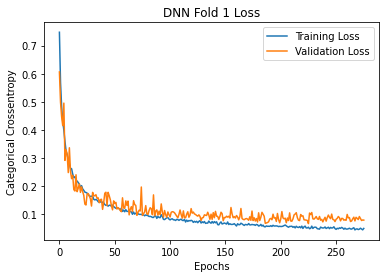

In [20]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_0.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('DNN Fold 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

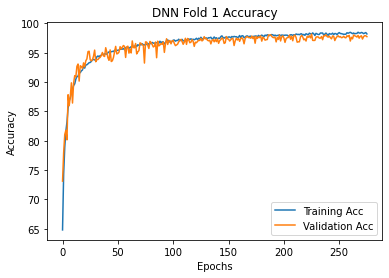

In [21]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_0.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('DNN Fold 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 2

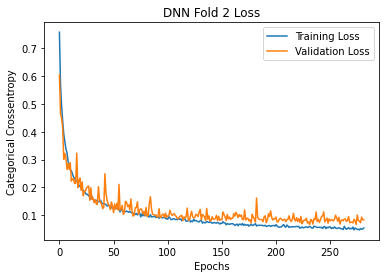

In [22]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_1.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('DNN Fold 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

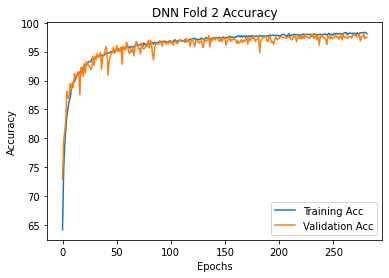

In [23]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_1.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('DNN Fold 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 3

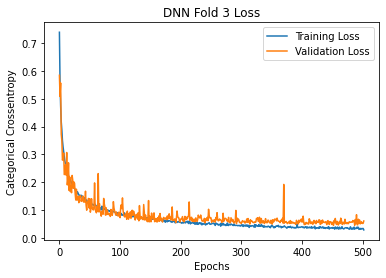

In [24]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_2.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('DNN Fold 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

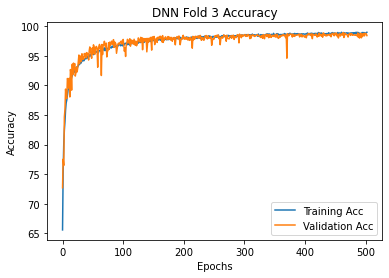

In [25]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_2.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('DNN Fold 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 4

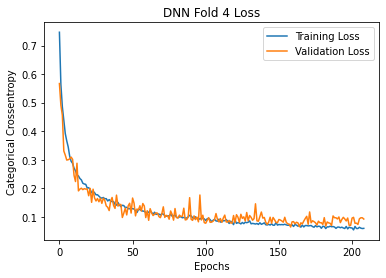

In [26]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_3.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('DNN Fold 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

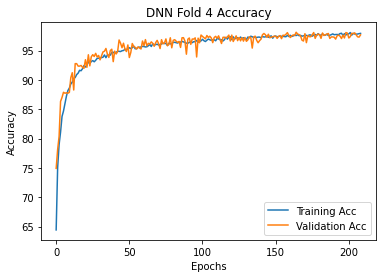

In [27]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_3.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('DNN Fold 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 5

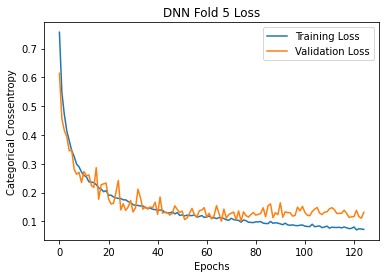

In [28]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_4.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('DNN Fold 5 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

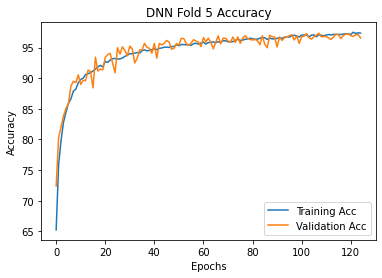

In [29]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_4.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('DNN Fold 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Final Accuracy and Loss

In [30]:
final_result = pd.concat([history_fold_0[-1:],
                          history_fold_1[-1:],
                          history_fold_2[-1:],
                          history_fold_3[-1:],
                          history_fold_4[-1:],
                         ])
final_result.columns = ['Last Training Loss (Crossentropy)', 'Last Training Accuracy', 'Last Validation Loss (Crossentropy)', 'Last Validation Accuracy']
final_result = final_result.reset_index(drop = True)
final_result.index += 1 
final_result.index.name = 'Fold'
final_result['Last Training Accuracy'] *= 100
final_result['Last Validation Accuracy'] *= 100
final_result['Last Training Loss (Crossentropy)'] = final_result['Last Training Loss (Crossentropy)'].round(5)
final_result['Last Validation Loss (Crossentropy)'] = final_result['Last Validation Loss (Crossentropy)'].round(5)
final_result['Last Training Accuracy'] = final_result['Last Training Accuracy'].round(2)
final_result['Last Validation Accuracy'] = final_result['Last Validation Accuracy'].round(2)

final_result

,Last Training Loss (Crossentropy),Last Training Accuracy,Last Validation Loss (Crossentropy),Last Validation Accuracy
Fold,,,,
1,0.04838,98.22,0.07799,97.76
2,0.05424,98.13,0.08344,97.40
3,0.02794,98.99,0.06014,98.42
4,0.05942,97.93,0.09207,97.67
5,0.07242,97.36,0.13173,96.57


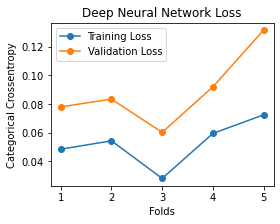

In [31]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Loss (Crossentropy)', 'Last Validation Loss (Crossentropy)']],'o-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Deep Neural Network Loss')
plt.xticks(np.arange(1,6,1))
plt.xlabel('Folds')
plt.ylabel('Categorical Crossentropy')
plt.show()

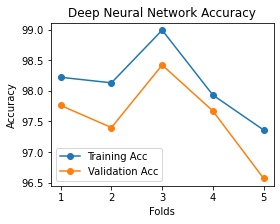

In [32]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Accuracy', 'Last Validation Accuracy']],'o-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('Deep Neural Network Accuracy')
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model.fit()